In [1]:
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from graphviz import Digraph

# 创建图对象
dot = Digraph(comment='ML Pipeline for Healthcare Fraud Detection')

# 输入数据节点
dot.node('A1', 'Beneficiary Info (KYC)')
dot.node('A2', 'Inpatient Claims')
dot.node('A3', 'Outpatient Claims')
dot.node('A4', 'Provider Fraud Labels')

# 主流程节点
dot.node('A', 'Data Loading')
dot.node('B', 'Data Integration & Merging')
dot.node('C', 'Feature Engineering')
dot.node('D', 'Model Training and Evaluation')
dot.node('E', 'Select Best Model (e.g., LightGBM)')
dot.node('F', 'SHAP Explainability Analysis')
dot.node('G', 'Model Performance Visualization')

# SHAP 图输出
dot.node('F1', 'SHAP Summary Plot')
dot.node('F2', 'SHAP Waterfall Plot')
dot.node('F3', 'SHAP Force Plot')

# 可视化输出图
dot.node('G1', 'Feature Importance (Bar)')
dot.node('G2', 'Confusion Matrix')
dot.node('G3', 'ROC Curve')

# 构建输入数据连接
dot.edges([('A1', 'A'), ('A2', 'A'), ('A3', 'A'), ('A4', 'A')])

# 主流程连接
dot.edges([('A', 'B'), ('B', 'C'), ('C', 'D'), ('D', 'E'), ('E', 'F'), ('E', 'G')])

# SHAP 输出连接
dot.edges([('F', 'F1'), ('F', 'F2'), ('F', 'F3')])

# 可视化输出连接
dot.edges([('G', 'G1'), ('G', 'G2'), ('G', 'G3')])

# ✅ 直接打印图像（在 Jupyter 中显示）
dot.view(cleanup=True)  # 打开图像预览，但不保留文件


'Digraph.gv.pdf'

In [3]:
import pandas as pd

# Step 1.1 读取训练数据
beneficiary_df = pd.read_csv('./content/Train_Beneficiarydata-1542865627584.csv')
inpatient_df = pd.read_csv('./content/Train_Inpatientdata-1542865627584.csv')
outpatient_df = pd.read_csv('./content/Train_Outpatientdata-1542865627584.csv')
train_label_df = pd.read_csv('./content/Train-1542865627584.csv')

# Step 1.2 添加标记区分门诊与住院
inpatient_df['Type'] = 'Inpatient'
outpatient_df['Type'] = 'Outpatient'

# Step 1.3 合并住院和门诊数据
claims_df = pd.concat([inpatient_df, outpatient_df], axis=0)

# Step 1.4 合并住院门诊 + 受益人信息（KYC）
claims_with_bene = claims_df.merge(beneficiary_df, on='BeneID', how='left')

# Step 1.5 合并上标签（fraud or not）
full_df = claims_with_bene.merge(train_label_df, on='Provider', how='left')

# 查看合并后的数据维度和前几行
print(f"合并后数据形状: {full_df.shape}")
full_df.head()


合并后数据形状: (558211, 56)


,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,...,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,...,1,1,2,1,1,36000,3204,60,70,Yes
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,...,1,1,2,1,1,36000,3204,60,70,No
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,...,1,1,2,1,1,36000,3204,60,70,No
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,...,1,2,2,1,1,5000,1068,250,320,No
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,...,2,1,2,2,2,21260,2136,120,100,No


In [4]:
# Feature Engineering
# Aggregate features per provider
agg_features = full_df.groupby('Provider').agg({
    'BeneID': 'nunique',  # number of unique beneficiaries
    'ClaimID': 'count',   # total number of claims
    'InscClaimAmtReimbursed': 'sum',
    'DeductibleAmtPaid': 'sum',
    'NoOfMonths_PartACov': 'mean',
    'NoOfMonths_PartBCov': 'mean',
    'IPAnnualReimbursementAmt': 'sum',
    'IPAnnualDeductibleAmt': 'sum',
    'OPAnnualReimbursementAmt': 'sum',
    'OPAnnualDeductibleAmt': 'sum',
    'PotentialFraud': 'first'
}).reset_index()

# Create binary label
agg_features['FraudLabel'] = (agg_features['PotentialFraud'] == 'Yes').astype(int)

print(f"Aggregated features shape: {agg_features.shape}")
agg_features.head()

Aggregated features shape: (5410, 13)


,Provider,BeneID,ClaimID,InscClaimAmtReimbursed,DeductibleAmtPaid,NoOfMonths_PartACov,NoOfMonths_PartBCov,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,PotentialFraud,FraudLabel
0,PRV51001,24,25,104640,5340.0,12.000000,12.000000,440150,22428,65380,11598,No,0
1,PRV51003,117,132,605670,66286.0,11.818182,11.871212,999000,122948,353520,97300,Yes,1
2,PRV51004,138,149,52170,310.0,11.865772,11.959732,648430,64808,327040,92790,No,0
3,PRV51005,495,1165,280910,3700.0,11.907296,11.939914,4221950,441724,2457840,741323,Yes,1
4,PRV51007,58,72,33710,3264.0,11.833333,11.833333,219600,32040,124540,33820,No,0


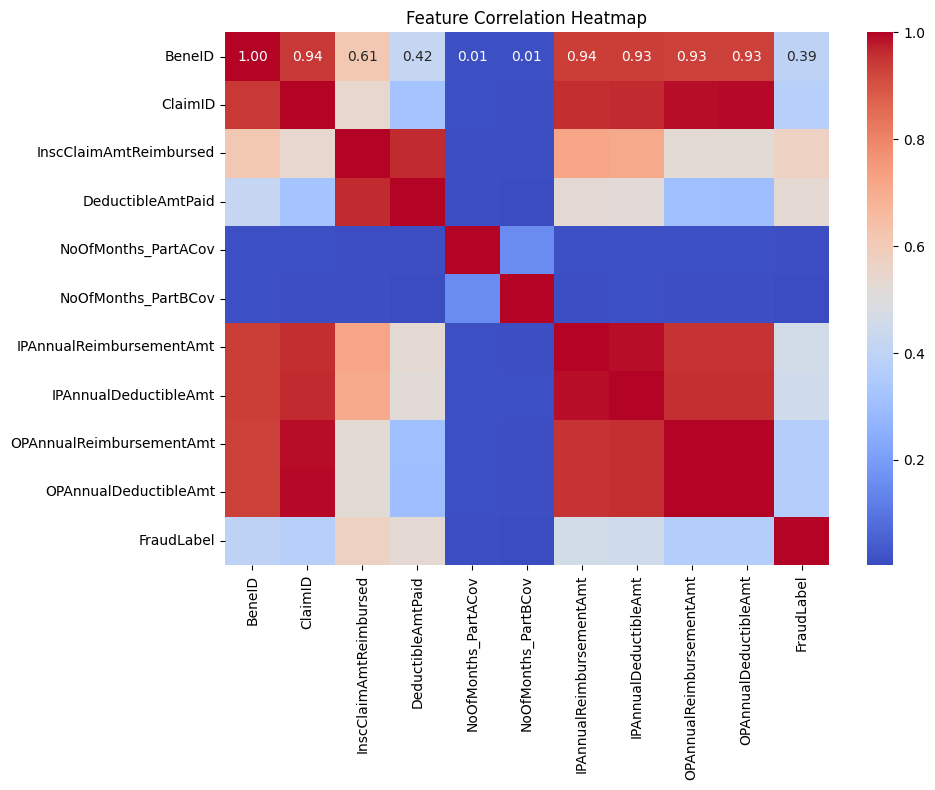

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 使用前面构造好的 Provider 聚合数据（例如 agg_features）
# 删除非数值列
corr_data = agg_features.drop(columns=['Provider', 'PotentialFraud'])

# 计算相关系数矩阵
corr_matrix = corr_data.corr()

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

In [6]:
# Step 2.1 处理缺失值
X = corr_data.drop(columns=['FraudLabel'])
X = X.fillna(X.median())  # 中位数填充
y = corr_data['FraudLabel']

# Step 2.2 数据划分
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2.3 模型定义
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
import lightgbm as lgb

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'KNN': KNeighborsClassifier(),
    'SVC': SVC(probability=True)
}

# Step 2.4 模型评估
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'AUC': roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(results_df)

# Save the best model
import os
os.makedirs('./models', exist_ok=True)
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
import pickle
with open('./models/best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

[LightGBM] [Info] Number of positive: 401, number of negative: 3927
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000247 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092652 -> initscore=-2.281670
[LightGBM] [Info] Start training from score -2.281670
                Model  Accuracy  Precision    Recall  F1-Score       AUC
5    GradientBoosting  0.923290   0.671875  0.409524  0.508876  0.928177
0  LogisticRegression  0.927911   0.736842  0.400000  0.518519  0.923634
4            LightGBM  0.926063   0.681159  0.447619  0.540230  0.912053
2        RandomForest  0.924214   0.671642  0.428571  0.523256  0.911079
3             XGBoost  0.922366   0.640000  0.457143  0.533333  0.902700
6       

In [7]:
best_model_name  

'GradientBoosting'

[LightGBM] [Info] Number of positive: 401, number of negative: 3927
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2550
[LightGBM] [Info] Number of data points in the train set: 4328, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.092652 -> initscore=-2.281670
[LightGBM] [Info] Start training from score -2.281670


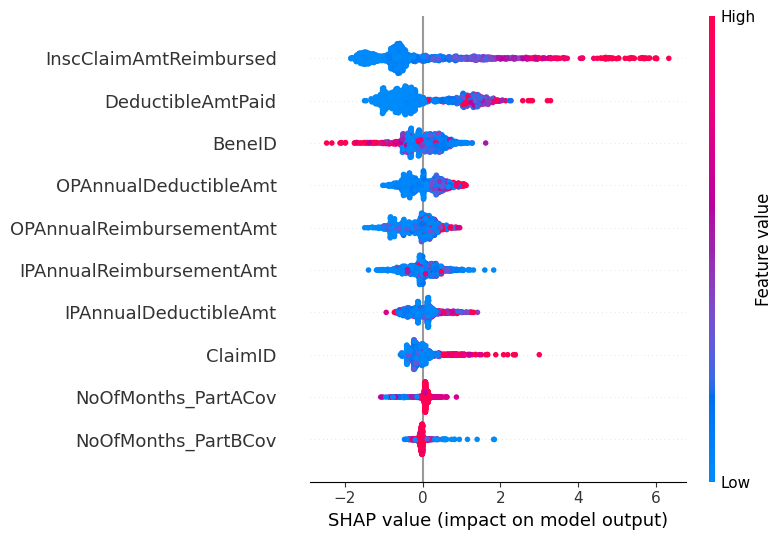

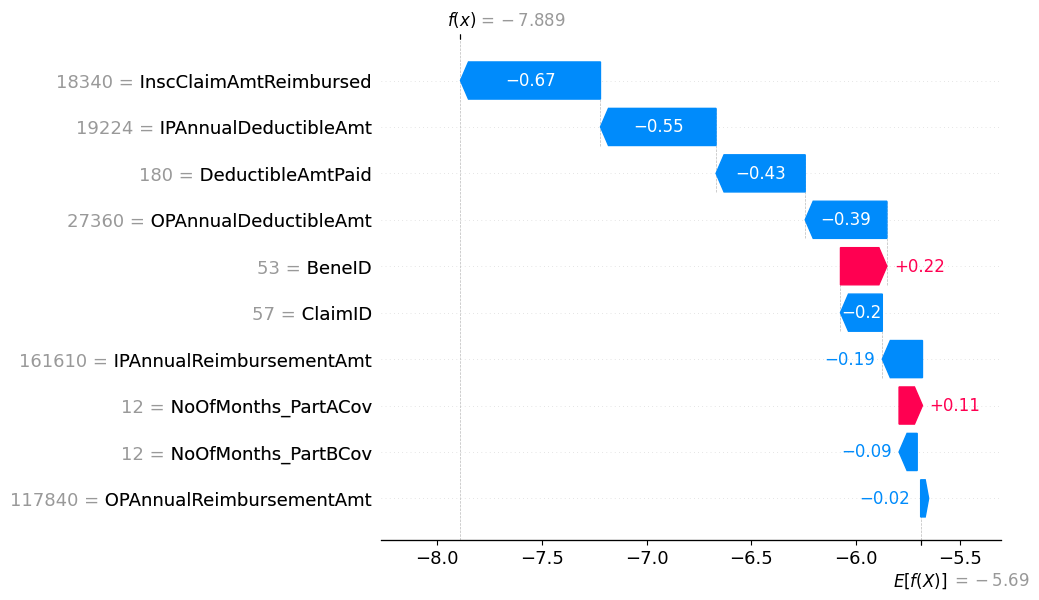

In [8]:
import shap

# 重新训练最佳模型
best_model = lgb.LGBMClassifier()
best_model.fit(X_train, y_train)

# 创建 SHAP Explainer（针对 LightGBM 推荐 TreeExplainer）
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)

# Save the explainer for API use
import pickle
with open('./models/shap_explainer.pkl', 'wb') as f:
    pickle.dump(explainer, f)

# 1️⃣ Summary Plot（全局重要性）
shap.summary_plot(shap_values, X_test)

# 2️⃣ Waterfall Plot（单样本局部解释）
shap.plots.waterfall(shap_values[0])

# 3️⃣ Force Plot（交互解释 - 适用于 Jupyter/Kaggle）
shap.initjs()
shap.plots.force(shap_values[0])  # ✅ 替代旧的 force_plot 写法

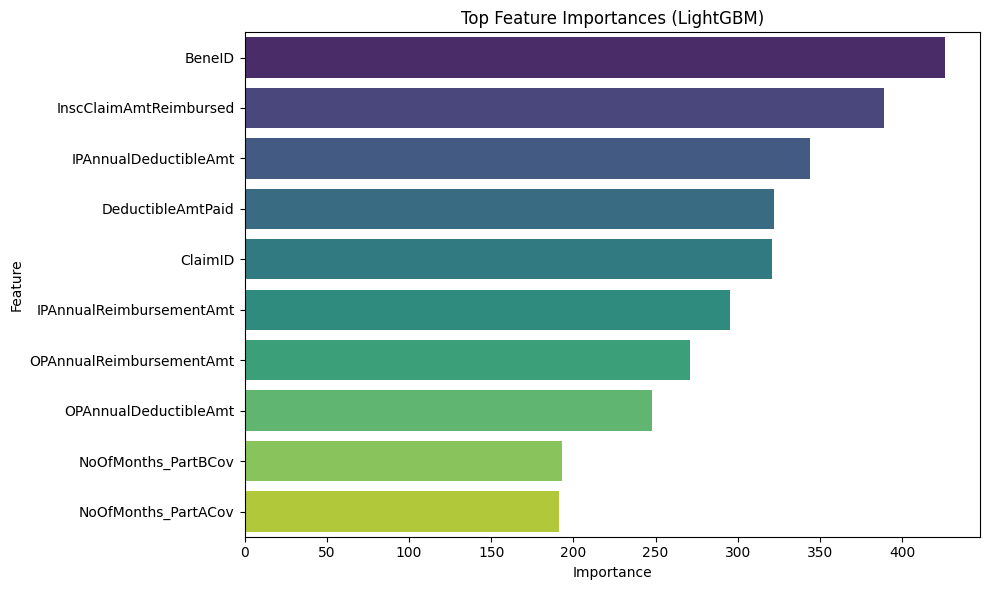

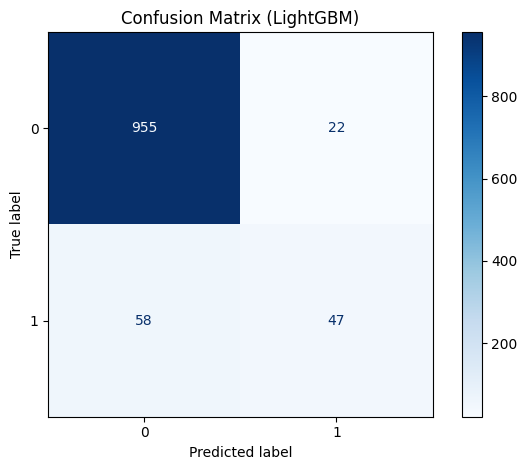

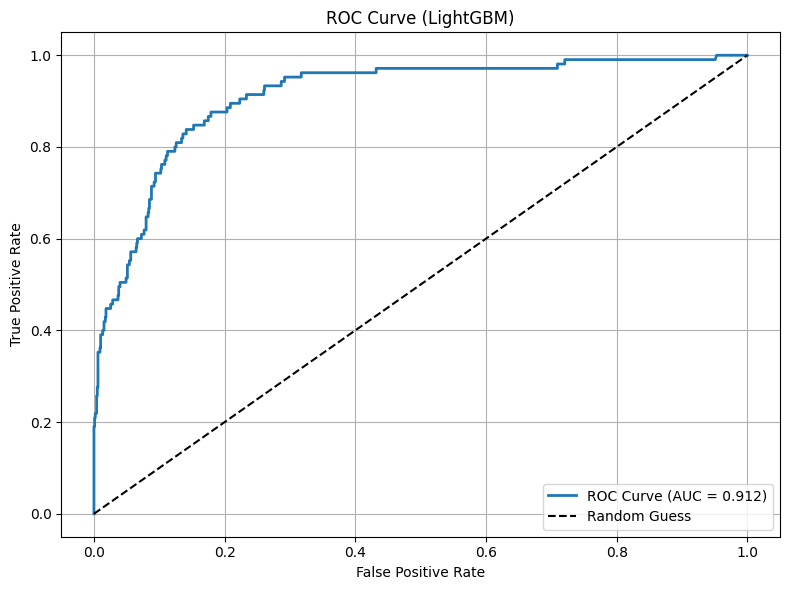

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# 1️⃣ 特征重要性条形图
importances = best_model.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feat_df, x='Importance', y='Feature', palette='viridis')
plt.title("Top Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()

# 2️⃣ 混淆矩阵
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='Blues')
plt.title("Confusion Matrix (LightGBM)")
plt.tight_layout()
plt.show()

# 3️⃣ ROC 曲线
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (LightGBM)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
